In [ ]:
import tensorflow as tf

print("Versión de tensorflow:{}".format(tf.__version__))
print("GPU:{}".format(tf.test.gpu_device_name()))


Versión de tensorflow:2.1.0
GPU:/device:GPU:0


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import pandas as pd
from tqdm.autonotebook import tqdm

E:\Program Files (x86)\Anaconda\envs\entornoGPU\lib\site-packages\ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [ ]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [ ]:
import os
import numpy as np
import tensorflow as tf

# Directorio que contiene tus imágenes
data_dir = 'C:\\Users\\USER\\Downloads\\train'

# Obtener la lista de nombres de archivo de las imágenes
file_names = os.listdir(data_dir)

# Cargar las imágenes
images = []
for file_name in file_names:
    image_path = os.path.join(data_dir, file_name)
    image = tf.image.decode_image(tf.io.read_file(image_path), channels=1)  # Asegurarse de cargar imágenes en escala de grises
    image = tf.image.resize(image, [28, 28]) / 255.0  # Redimensionar y normalizar
    images.append(image)

# Convertir la lista de imágenes a un tensor
images = np.array(images)

# Separar conjunto de entrenamiento y prueba (aquí usamos todas las imágenes para entrenamiento)
train_images = images.astype("float32")

# Batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(len(train_images))
    .batch(BATCH_SIZE)
)

# Porción de las imágenes para el conjunto de datos de prueba (puedes ajustar el tamaño según sea necesario)
num_test_images = 1000
test_images = train_images[:num_test_images]

# Batch dataset de prueba
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(len(test_images))
    .batch(BATCH_SIZE)
)


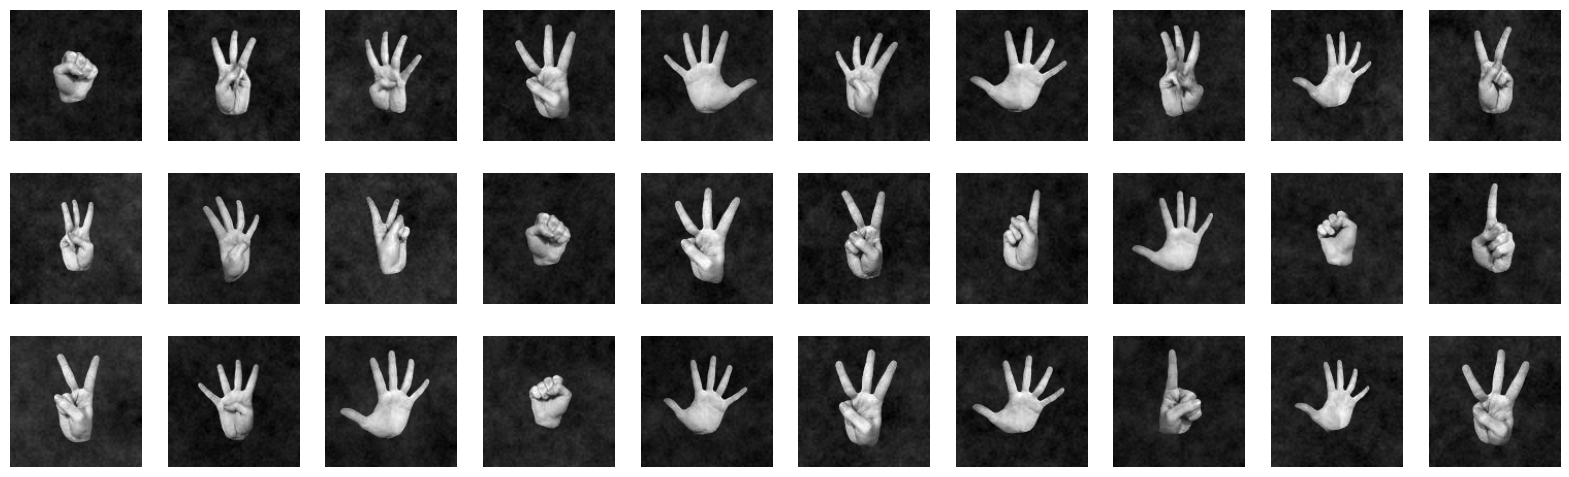

In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf

# Directorio que contiene tus imágenes
data_dir = 'C:\\Users\\USER\\Downloads\\train'

# Obtener la lista de nombres de archivo de las imágenes
file_names = os.listdir(data_dir)

# Cargar y mostrar las primeras 30 imágenes originales
fig, axes = plt.subplots(3, 10, figsize=(20, 6))  # Configurar la figura con 3 filas y 10 columnas
for i, file_name in enumerate(file_names[:30]):  # Limitar a las primeras 30 imágenes
    row = i // 10  # Calcular la fila actual
    col = i % 10   # Calcular la columna actual
    image_path = os.path.join(data_dir, file_name)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)  # Decodificar la imagen en escala de grises
    axes[row, col].imshow(image.numpy().squeeze(), cmap='gray')  # Mostrar en escala de grises
    axes[row, col].axis('off')  # Ocultar los ejes

plt.show()



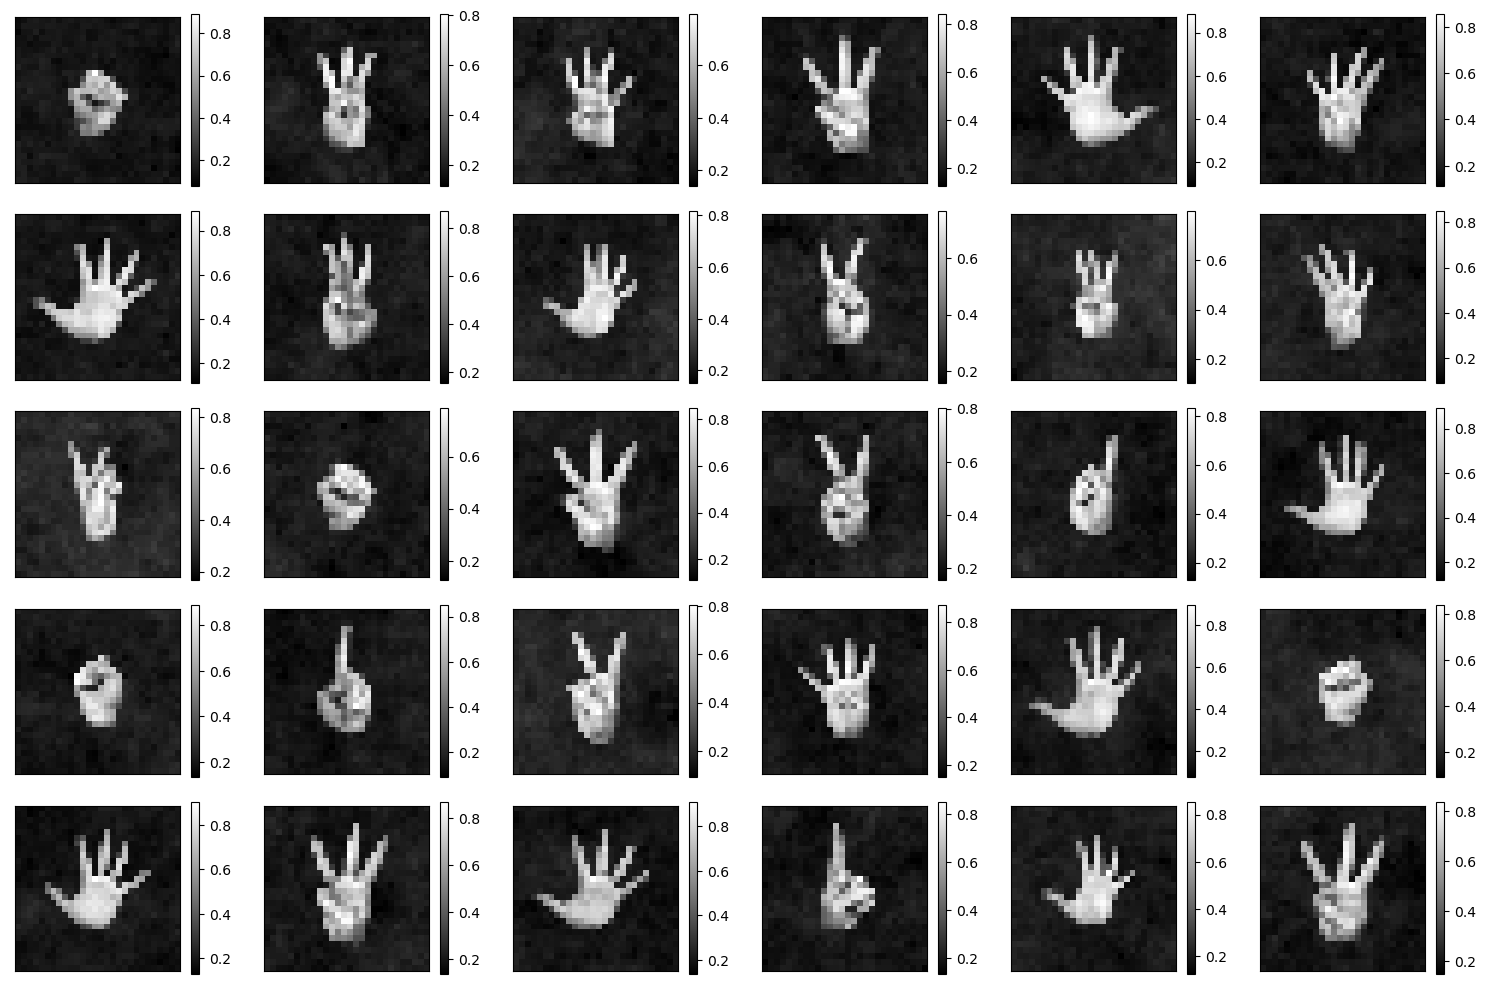

In [ ]:
import matplotlib.pyplot as plt

# Función para visualizar varias imágenes en una cuadrícula
def plot_images(images, rows, cols):
    plt.figure(figsize=(15, 10))  # Ajusta el tamaño de la figura total
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)  # Crea un subplot para cada imagen
        plt.imshow(image.squeeze(), cmap='gray')  # Muestra la imagen en escala de grises
        plt.colorbar()  # Opcional: muestra una barra de color para entender los valores de los píxeles
        plt.grid(False)  # Desactiva la cuadrícula para una visualización más clara
        plt.xticks([])  # Elimina las marcas en el eje X
        plt.yticks([])  # Elimina las marcas en el eje Y
    plt.tight_layout()  # Ajusta automáticamente los subplots para que encajen en la figura
    plt.show()

# Visualizar las primeras 30 imágenes del conjunto de datos
plot_images(train_images[:30], rows=5, cols=6)





In [ ]:
class GAN(tf.keras.Model):
    """ a basic GAN class
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)


def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )

In [ ]:
N_Z = 64
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [ ]:
import tensorflow as tf

# Definir las dimensiones de entrada
DIMS = (28, 28, 1)

# Definir el generador como un modelo secuencial
generator = tf.keras.Sequential(generator)

# Definir el discriminador como un modelo secuencial
discriminator = tf.keras.Sequential(discriminator)

# Construir el generador
generator.build(input_shape=(None, N_Z))  # Suponiendo que N_Z es la dimensión de la entrada del generador

# Construir el discriminador
discriminator.build(input_shape=(None,) + DIMS)

# Imprimir la arquitectura del generador
print("Generador:")
generator.summary()

# Imprimir la arquitectura del discriminador
print("\nDiscriminador:")
discriminator.summary()


Generador:
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  203840    
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr multiple                  73856     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr multiple                  73792     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr multiple                  577       
Total params: 352,065
Trainable params: 352,065
Non-trainable params: 0
_________________________________________________________________

Discriminador:
Model: "sequential_5"
_________________________________________________________________

In [ ]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

Epoch 80: disc_loss: 0.25041675567626953 | gen_loss: 3.6726584434509277
Epoch 1: disc_loss: 0.7835686206817627 | gen_loss: 1.0942738056182861
Epoch 1


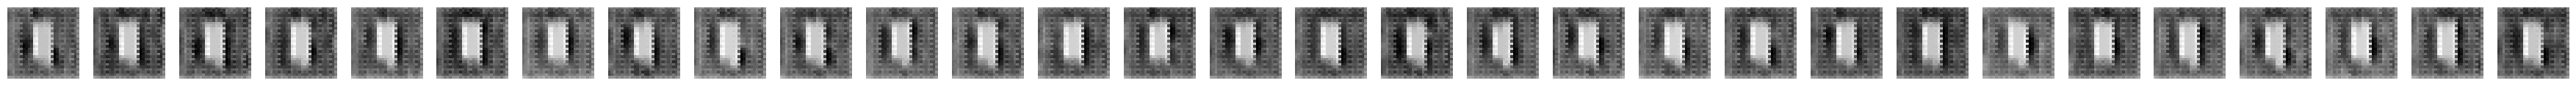

Epoch 2: disc_loss: 0.6531029343605042 | gen_loss: 1.8117551803588867
Epoch 2


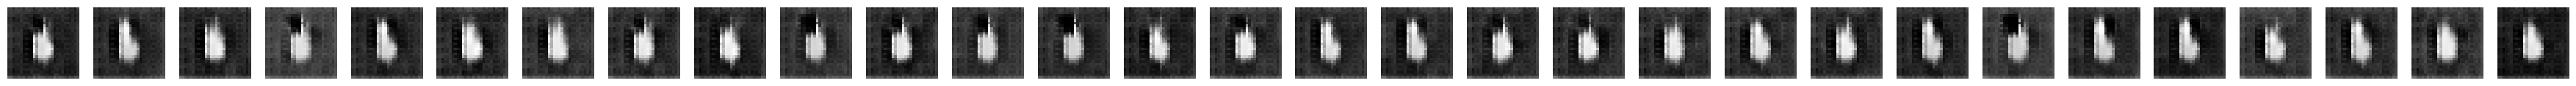

Epoch 3: disc_loss: 0.5516205430030823 | gen_loss: 1.675800085067749
Epoch 3


Epoch 4: disc_loss: 0.7549235820770264 | gen_loss: 1.6651182174682617
Epoch 4


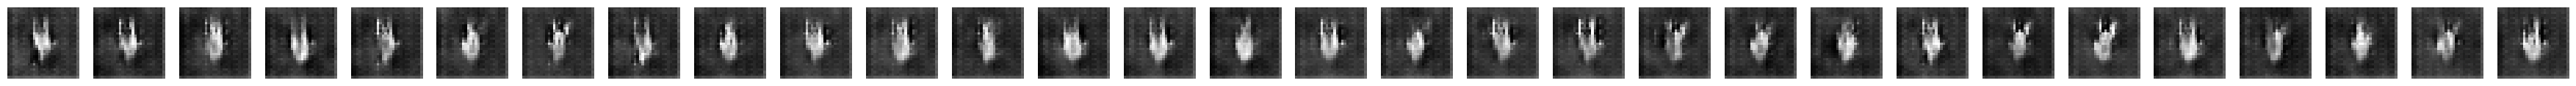

Epoch 5: disc_loss: 0.48435544967651367 | gen_loss: 1.799034595489502
Epoch 5


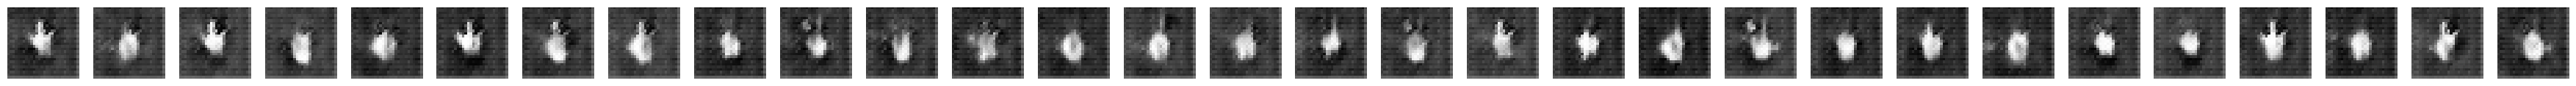

Epoch 6: disc_loss: 0.4796873927116394 | gen_loss: 1.8069376945495605
Epoch 6


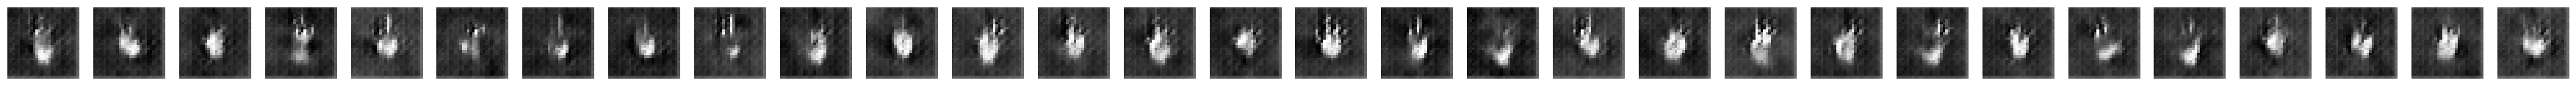

Epoch 7: disc_loss: 1.0615200996398926 | gen_loss: 2.715693235397339
Epoch 7


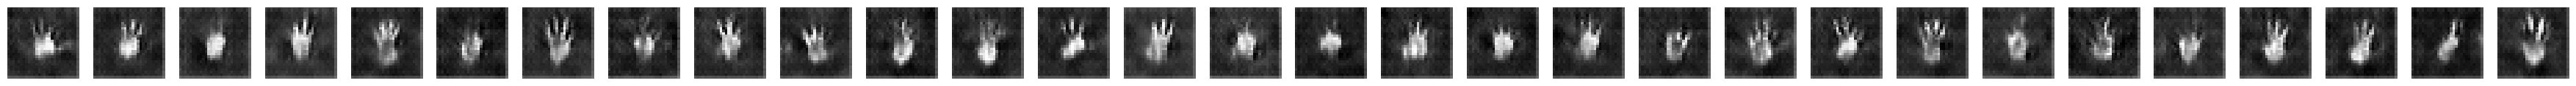

Epoch 8: disc_loss: 0.8643887042999268 | gen_loss: 0.8002693057060242
Epoch 8


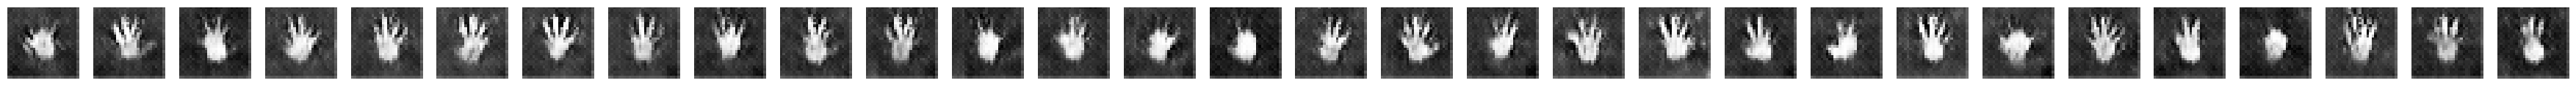

Epoch 9: disc_loss: 0.6580051183700562 | gen_loss: 1.263852834701538
Epoch 9


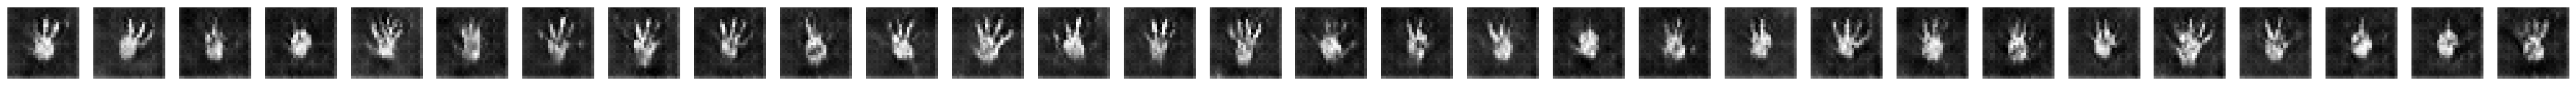

Epoch 10: disc_loss: 0.7884280681610107 | gen_loss: 1.3462820053100586
Epoch 10


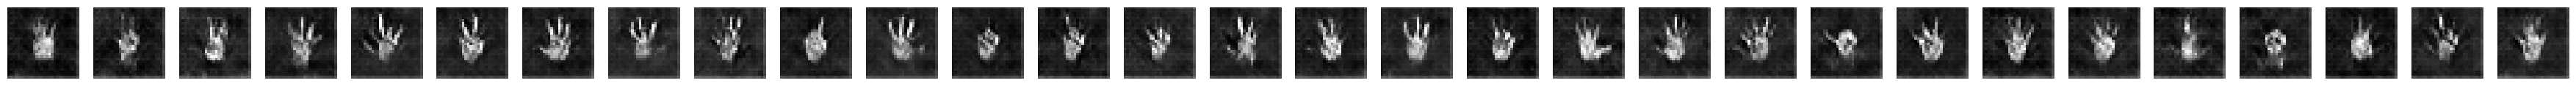

Epoch 11: disc_loss: 0.68631511926651 | gen_loss: 1.3038411140441895
Epoch 11


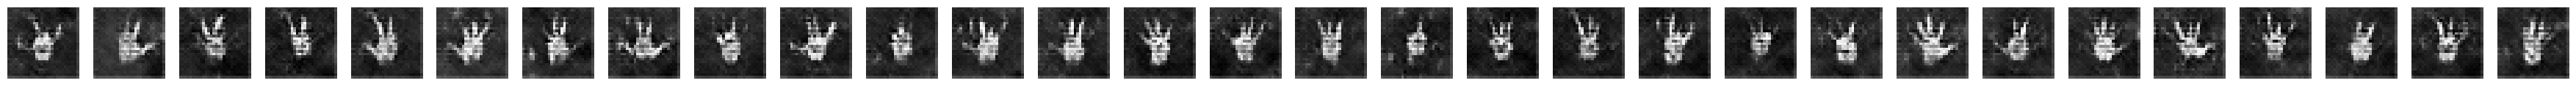

Epoch 12: disc_loss: 0.7473267912864685 | gen_loss: 1.9081225395202637
Epoch 12


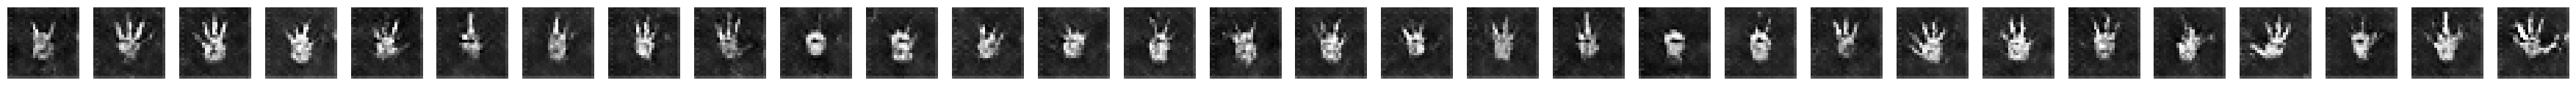

Epoch 13: disc_loss: 1.148252248764038 | gen_loss: 0.5432093739509583
Epoch 13


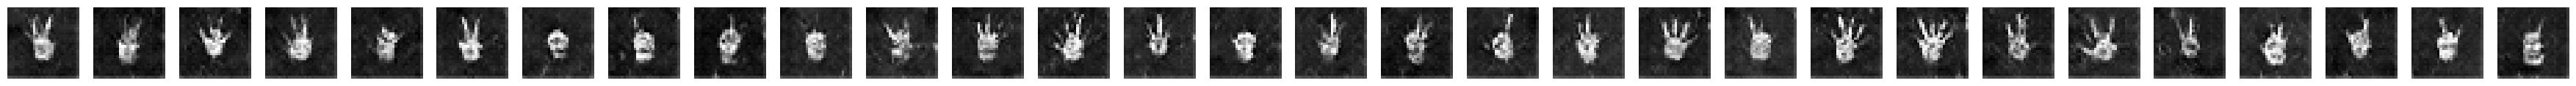

Epoch 14: disc_loss: 0.7486168742179871 | gen_loss: 1.4786075353622437
Epoch 14


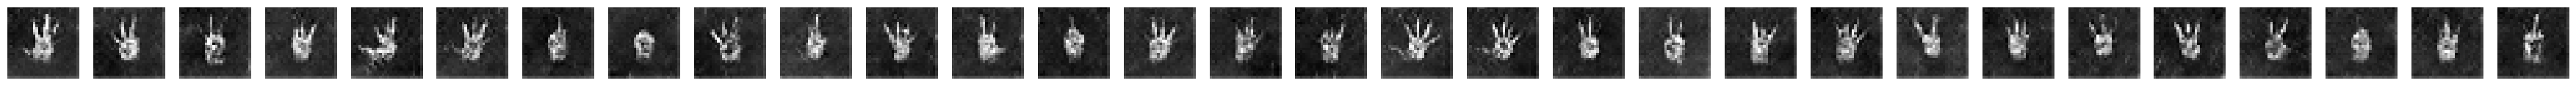

Epoch 15: disc_loss: 0.571840226650238 | gen_loss: 1.3899526596069336
Epoch 15


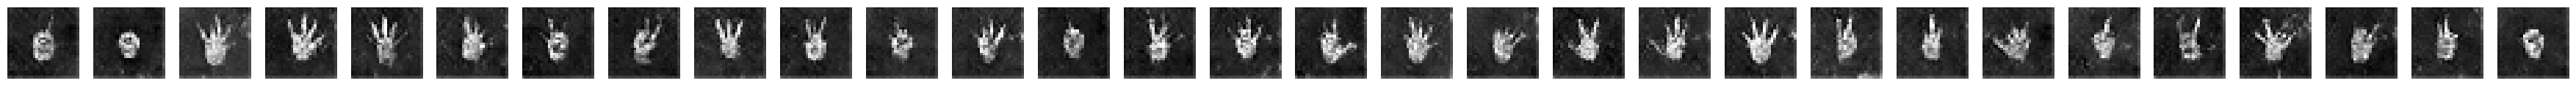

Epoch 16: disc_loss: 0.6026840806007385 | gen_loss: 1.995937466621399
Epoch 16


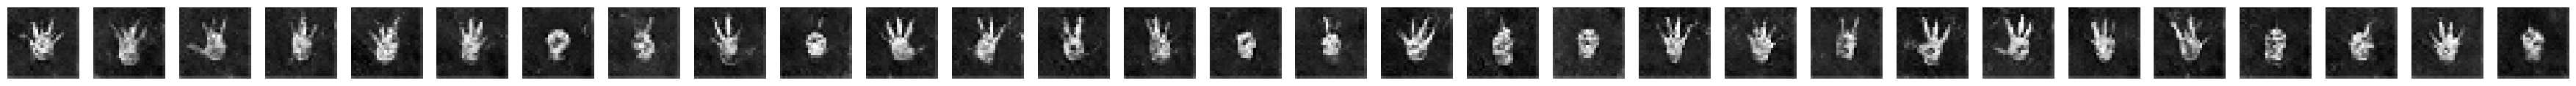

Epoch 17: disc_loss: 0.9160506725311279 | gen_loss: 0.8465986251831055
Epoch 17


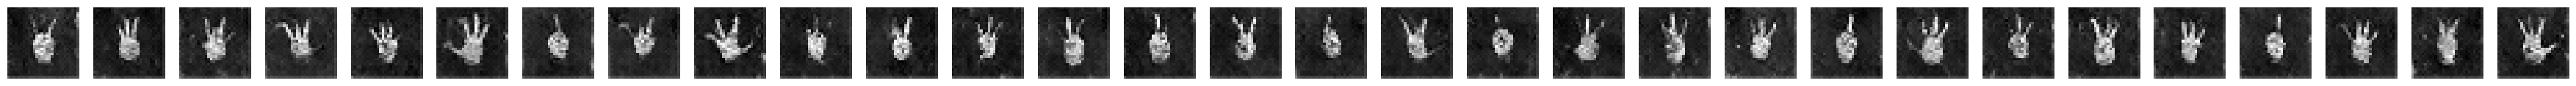

Epoch 18: disc_loss: 0.6023635864257812 | gen_loss: 1.2471518516540527
Epoch 18


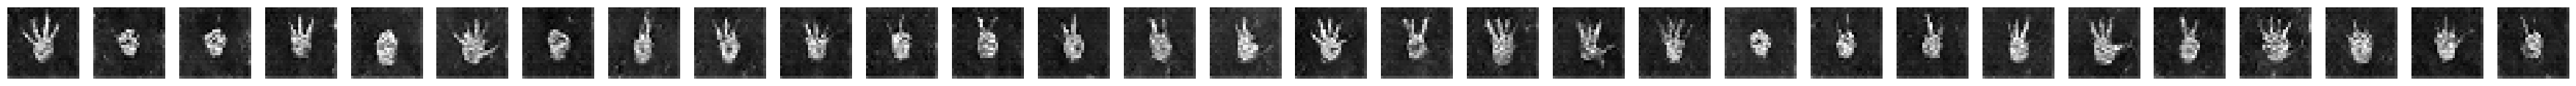

Epoch 19: disc_loss: 1.2471803426742554 | gen_loss: 2.5124659538269043
Epoch 19


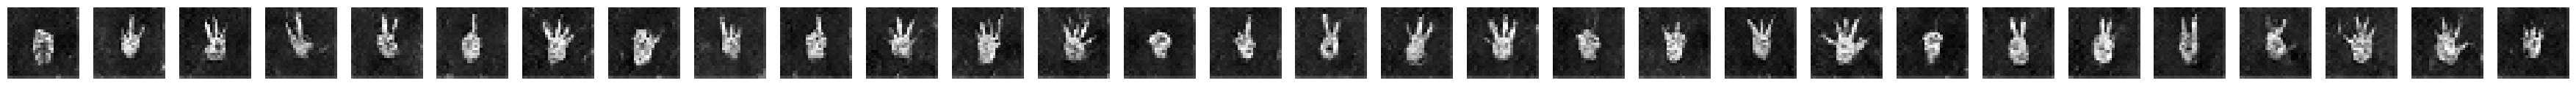

Epoch 20: disc_loss: 0.6005459427833557 | gen_loss: 3.149962902069092
Epoch 20


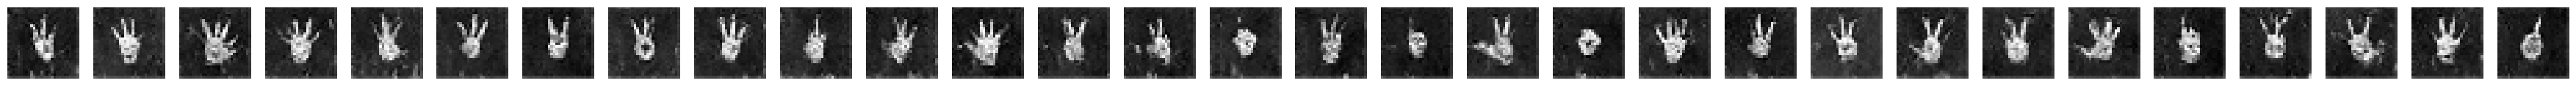

Epoch 21: disc_loss: 0.674078643321991 | gen_loss: 1.1337566375732422
Epoch 21


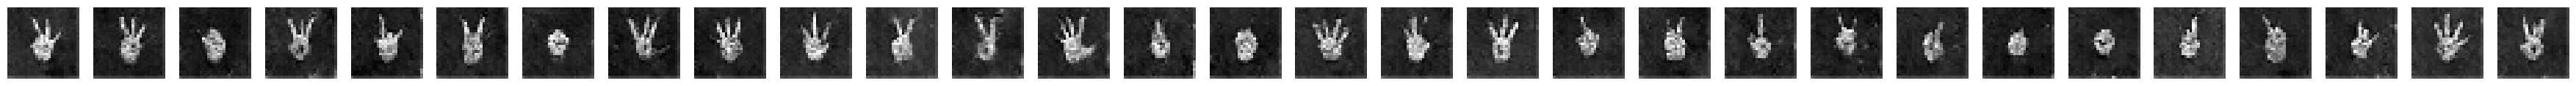

Epoch 22: disc_loss: 0.6532062292098999 | gen_loss: 2.211731433868408
Epoch 22


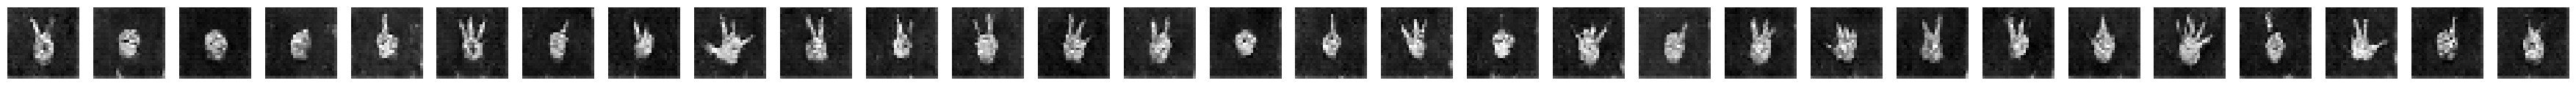

Epoch 23: disc_loss: 0.5692510008811951 | gen_loss: 1.2926890850067139
Epoch 23


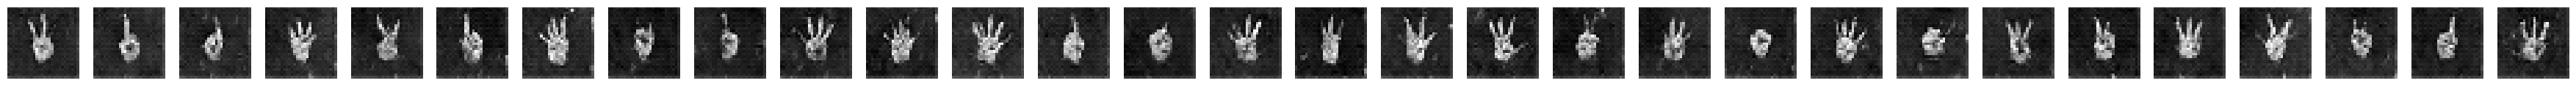

Epoch 24: disc_loss: 0.6984380483627319 | gen_loss: 2.714212656021118
Epoch 24


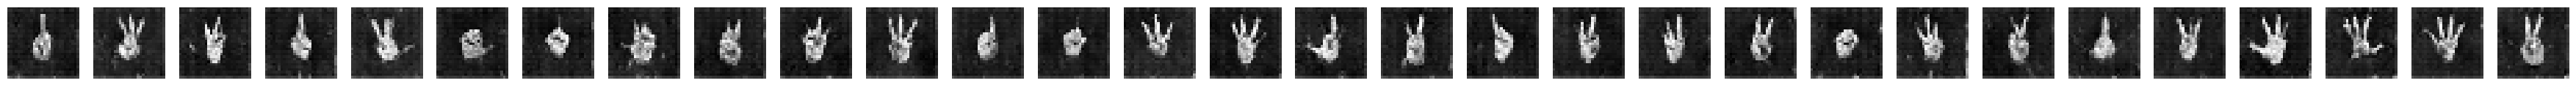

Epoch 25: disc_loss: 0.8641558885574341 | gen_loss: 0.8866428136825562
Epoch 25


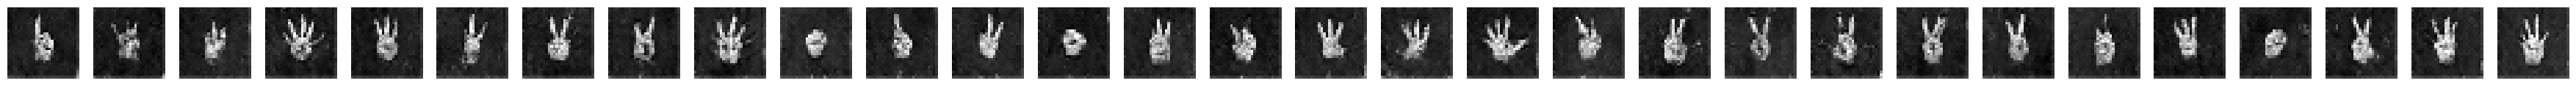

Epoch 26: disc_loss: 0.6311542987823486 | gen_loss: 2.4492921829223633
Epoch 26


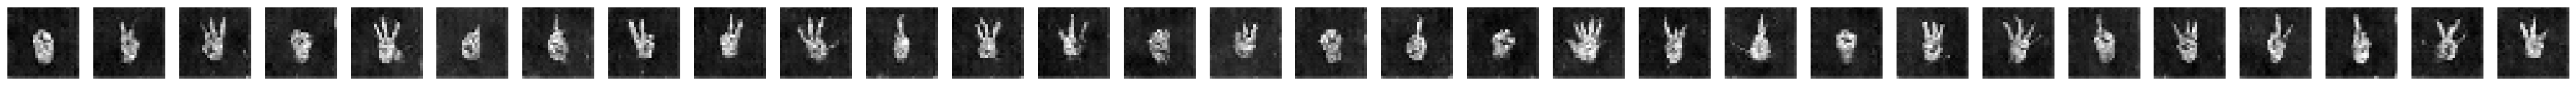

Epoch 27: disc_loss: 0.6005688905715942 | gen_loss: 1.3789550065994263
Epoch 27


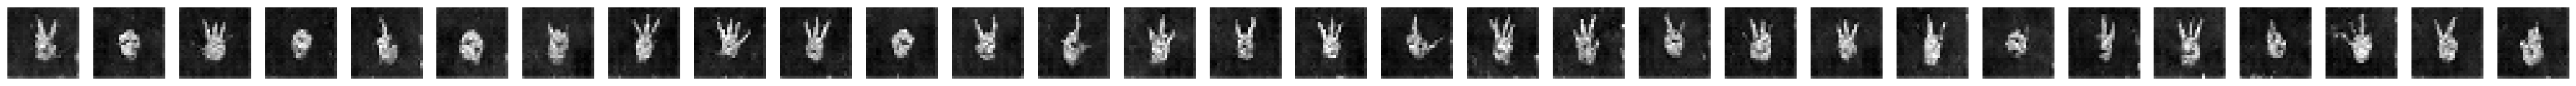

Epoch 28: disc_loss: 0.5820931792259216 | gen_loss: 2.7165746688842773
Epoch 28


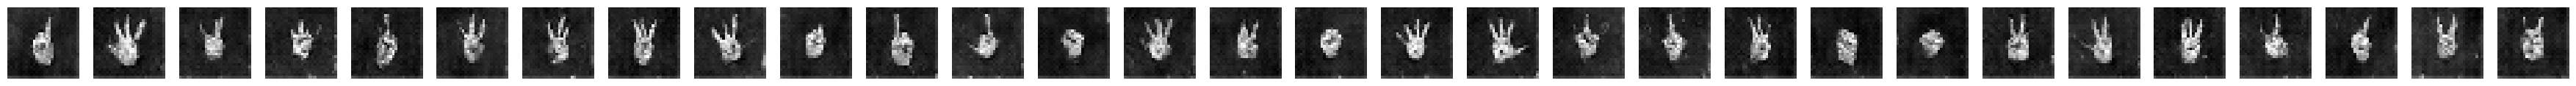

Epoch 29: disc_loss: 0.7081794738769531 | gen_loss: 3.184378147125244
Epoch 29


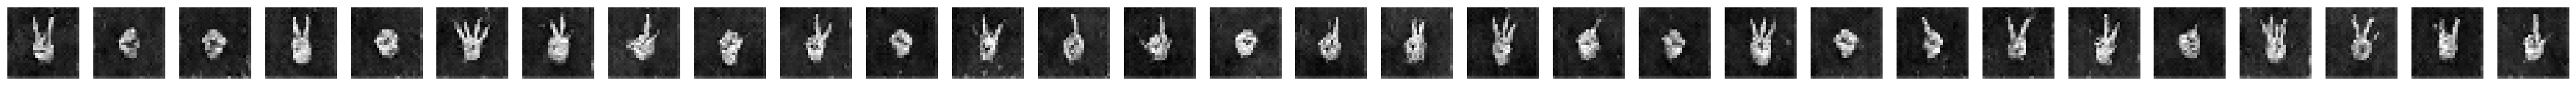

Epoch 30: disc_loss: 0.486002653837204 | gen_loss: 1.6335989236831665
Epoch 30


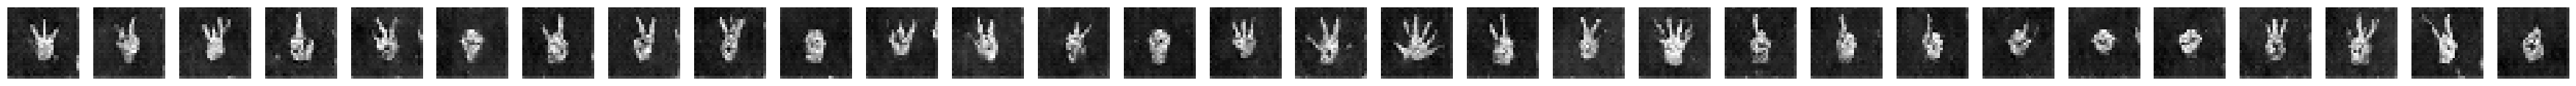

Epoch 31: disc_loss: 0.6047714948654175 | gen_loss: 2.477932929992676
Epoch 31


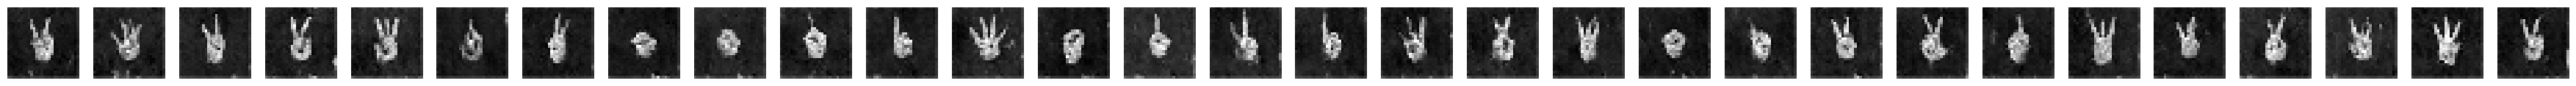

Epoch 32: disc_loss: 0.6604759693145752 | gen_loss: 1.1371240615844727
Epoch 32


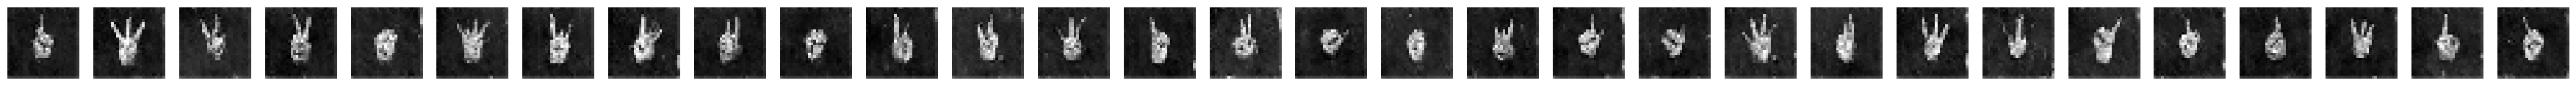

Epoch 33: disc_loss: 0.6556745767593384 | gen_loss: 3.716594696044922
Epoch 33


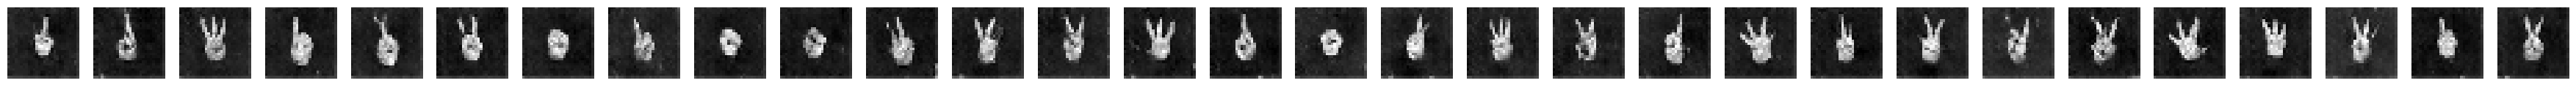

Epoch 34: disc_loss: 0.5892606973648071 | gen_loss: 1.4914261102676392
Epoch 34


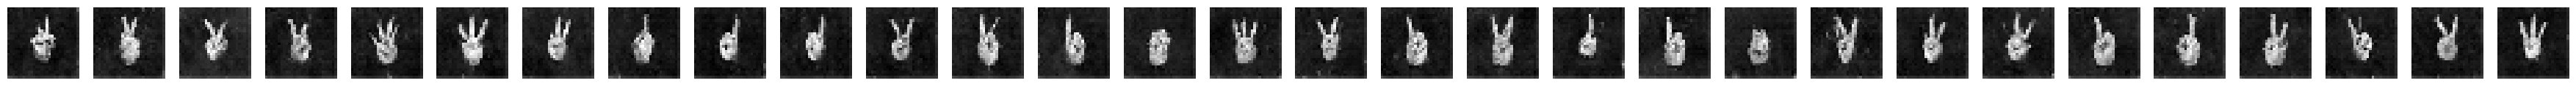

Epoch 35: disc_loss: 0.5107566714286804 | gen_loss: 2.7281556129455566
Epoch 35


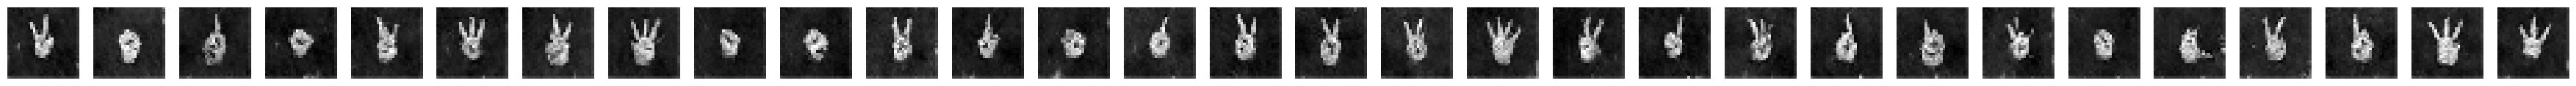

Epoch 36: disc_loss: 0.4208392798900604 | gen_loss: 1.9330921173095703
Epoch 36


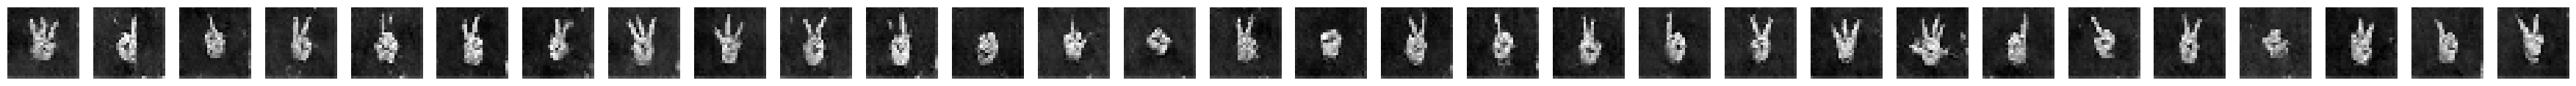

Epoch 37: disc_loss: 0.3948344588279724 | gen_loss: 2.7374162673950195
Epoch 37


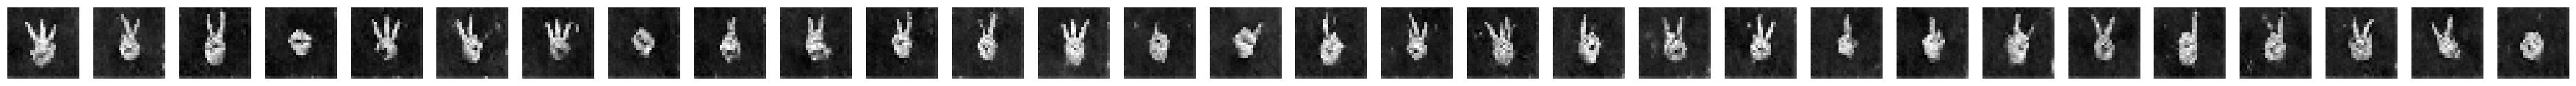

Epoch 38: disc_loss: 0.4278761148452759 | gen_loss: 1.6047875881195068
Epoch 38


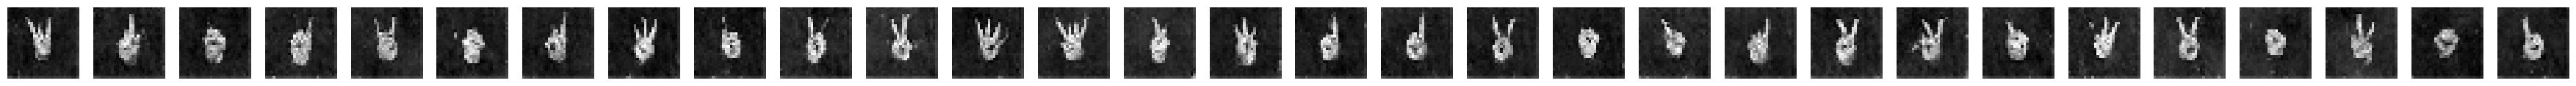

Epoch 39: disc_loss: 0.6106808185577393 | gen_loss: 3.4278597831726074
Epoch 39


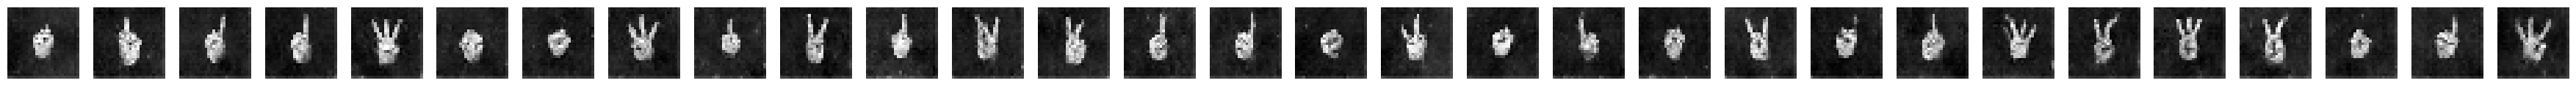

Epoch 40: disc_loss: 0.5958266854286194 | gen_loss: 1.3130273818969727
Epoch 40


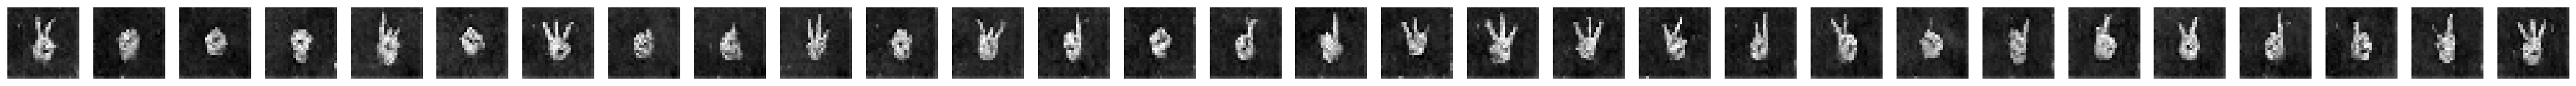

Epoch 41: disc_loss: 0.4734053909778595 | gen_loss: 1.5868537425994873
Epoch 41


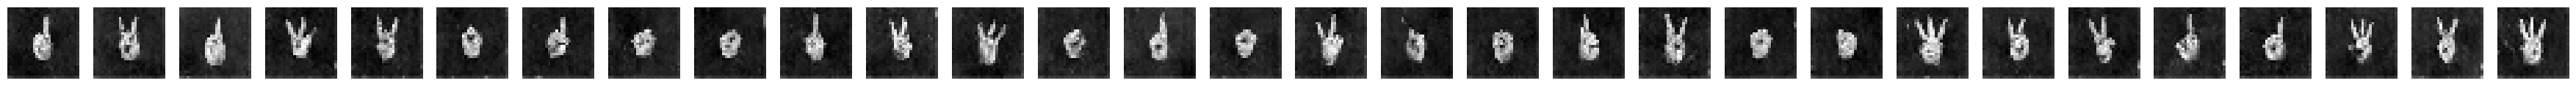

Epoch 42: disc_loss: 0.354144811630249 | gen_loss: 2.8776662349700928
Epoch 42


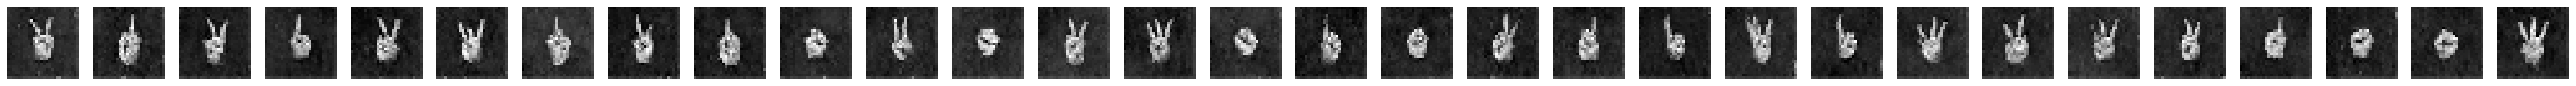

Epoch 43: disc_loss: 0.48560869693756104 | gen_loss: 1.551967978477478
Epoch 43


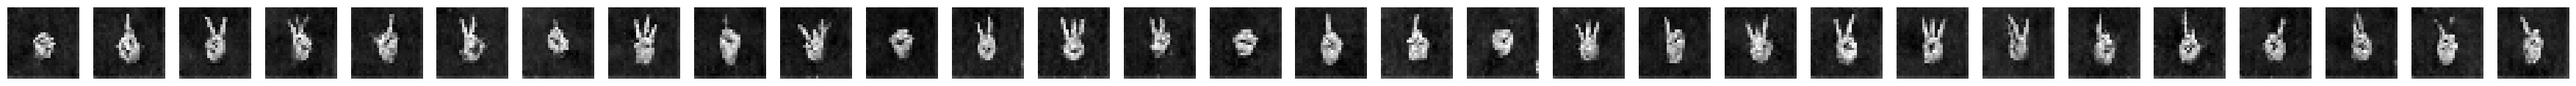

Epoch 44: disc_loss: 0.27135854959487915 | gen_loss: 3.357767105102539
Epoch 44


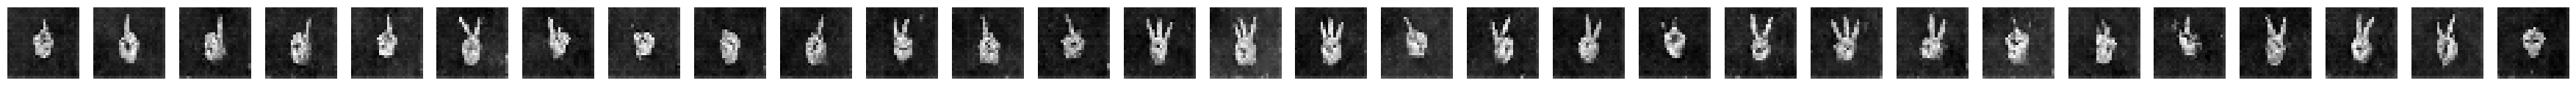

Epoch 45: disc_loss: 0.32148587703704834 | gen_loss: 2.345783233642578
Epoch 45


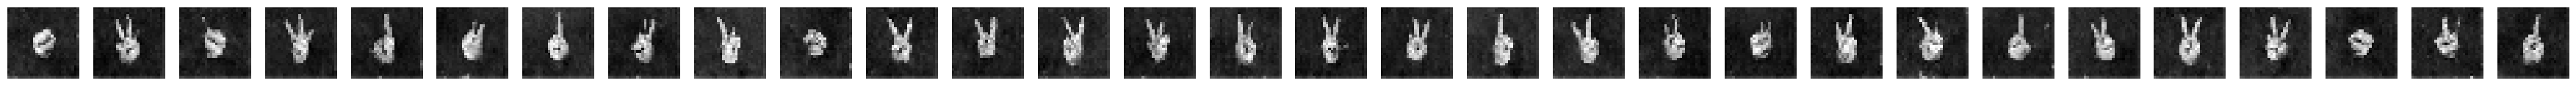

Epoch 46: disc_loss: 0.43279218673706055 | gen_loss: 2.6260509490966797
Epoch 46


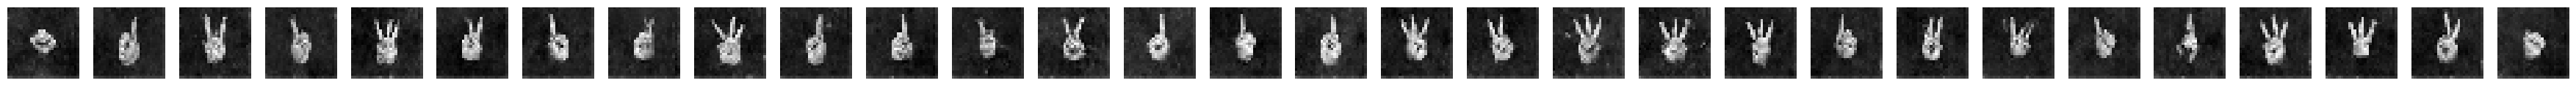

Epoch 47: disc_loss: 0.35516536235809326 | gen_loss: 2.4010138511657715
Epoch 47


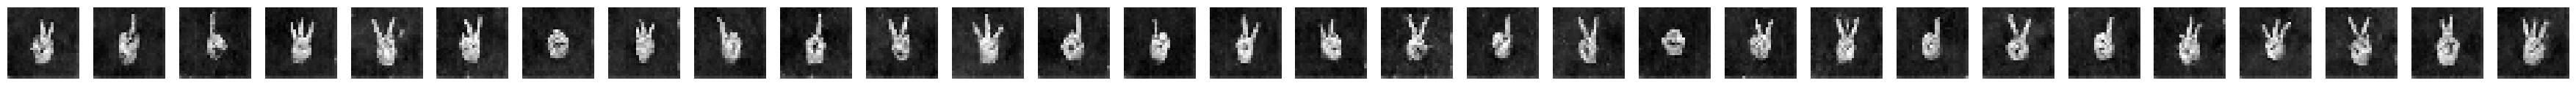

Epoch 48: disc_loss: 0.4020809829235077 | gen_loss: 2.6150307655334473
Epoch 48


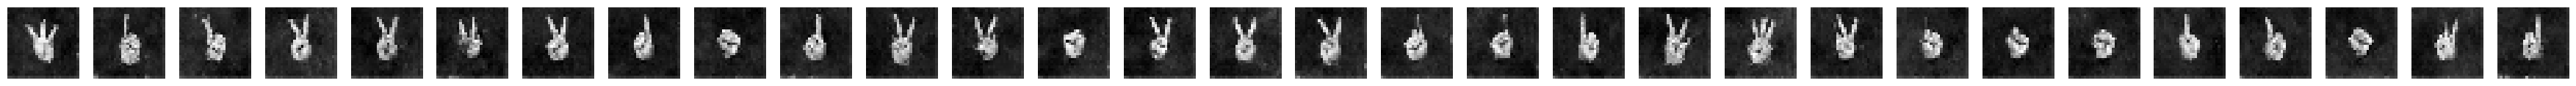

Epoch 49: disc_loss: 0.35538458824157715 | gen_loss: 2.1161327362060547
Epoch 49


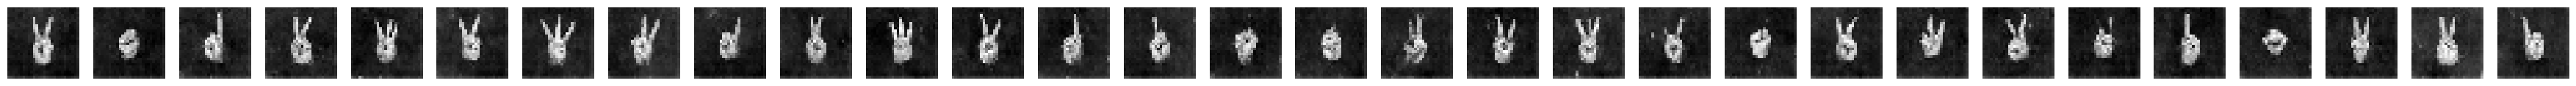

Epoch 50: disc_loss: 0.30466827750205994 | gen_loss: 2.2167906761169434
Epoch 50


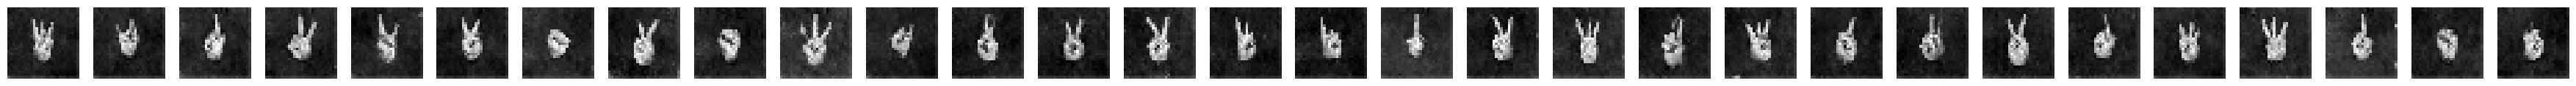

Epoch 51: disc_loss: 0.2148362100124359 | gen_loss: 3.3847289085388184
Epoch 51


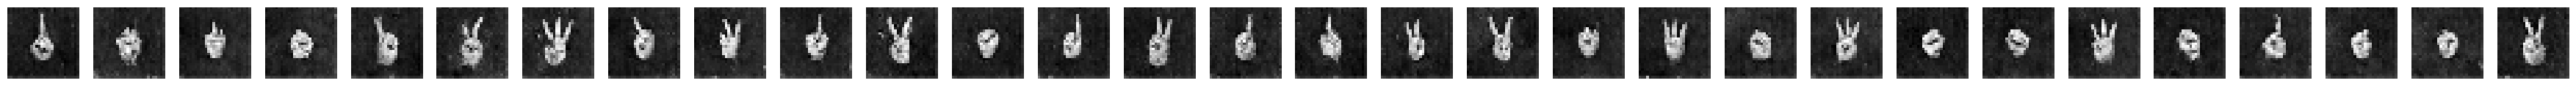

Epoch 52: disc_loss: 0.37647053599357605 | gen_loss: 3.549241304397583
Epoch 52


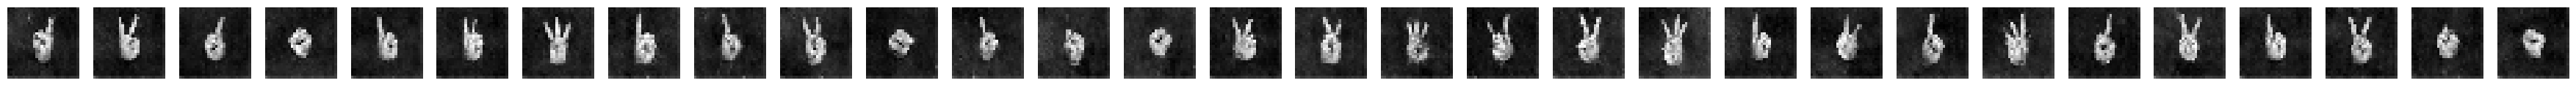

Epoch 53: disc_loss: 0.5177665948867798 | gen_loss: 4.363971710205078
Epoch 53


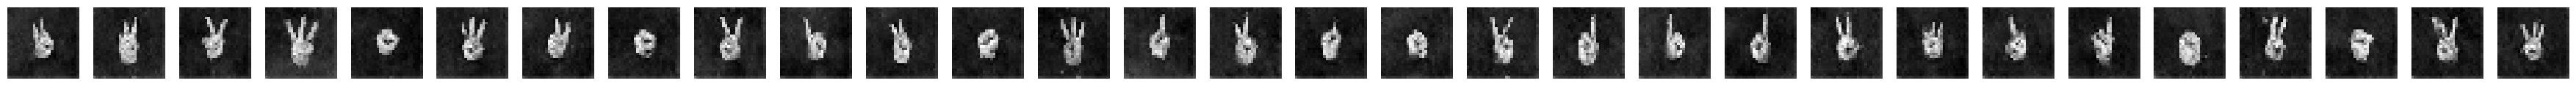

Epoch 54: disc_loss: 0.2994180917739868 | gen_loss: 2.3379337787628174
Epoch 54


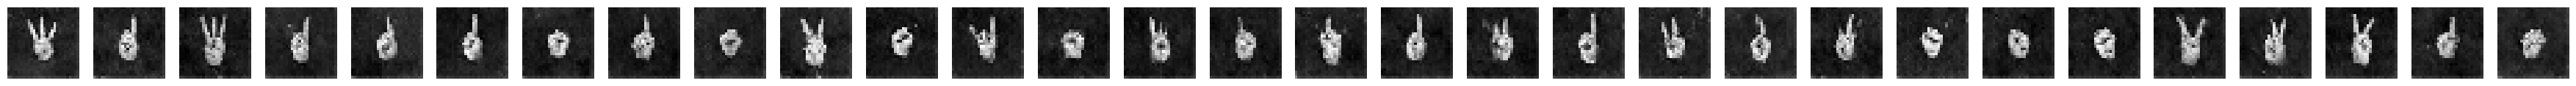

Epoch 55: disc_loss: 0.4246385991573334 | gen_loss: 4.726225852966309
Epoch 55


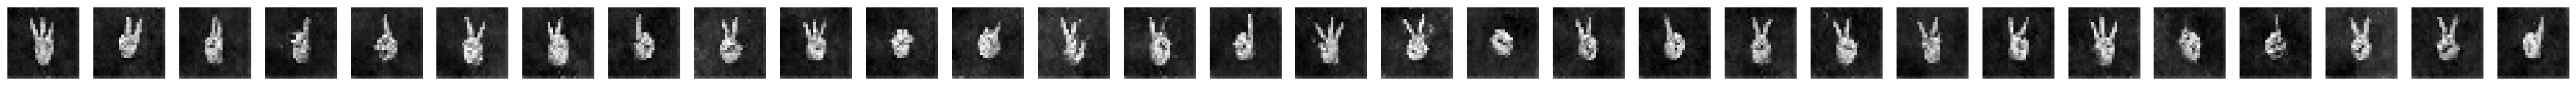

Epoch 56: disc_loss: 0.2384340465068817 | gen_loss: 2.889059066772461
Epoch 56


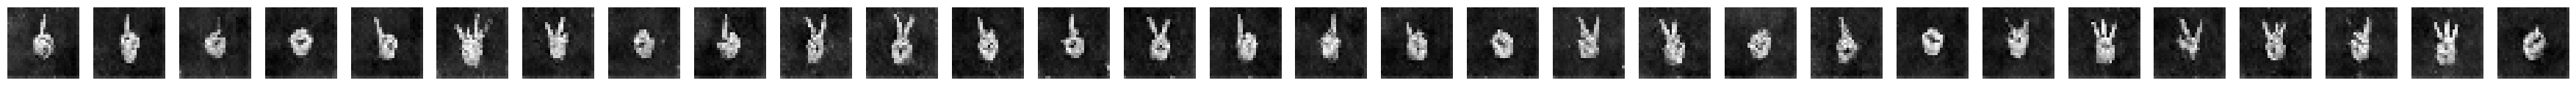

Epoch 57: disc_loss: 0.3341830372810364 | gen_loss: 2.3290703296661377
Epoch 57


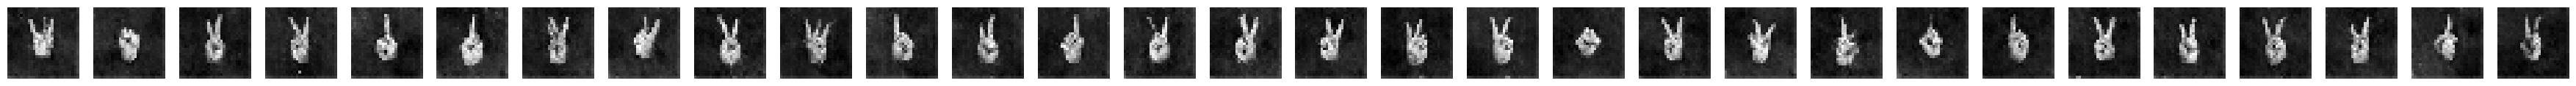

Epoch 58: disc_loss: 0.254658579826355 | gen_loss: 3.3930420875549316
Epoch 58


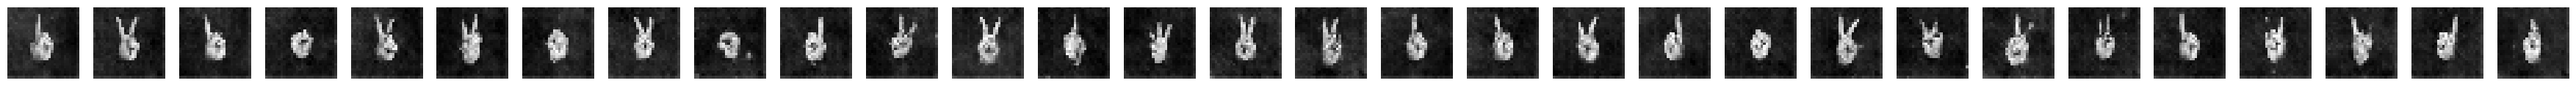

Epoch 59: disc_loss: 0.44253140687942505 | gen_loss: 4.417422294616699
Epoch 59


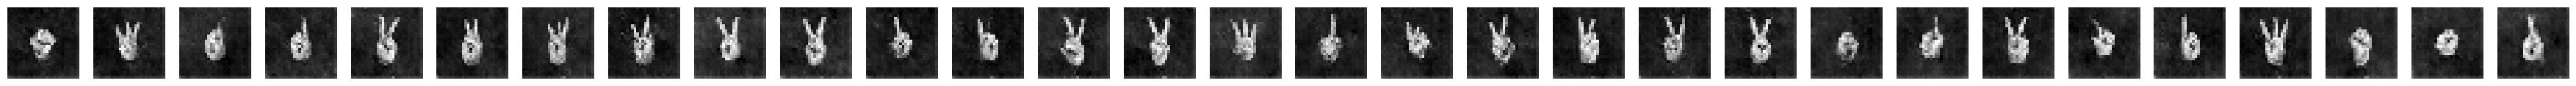

Epoch 60: disc_loss: 0.2155836969614029 | gen_loss: 3.007996082305908
Epoch 60


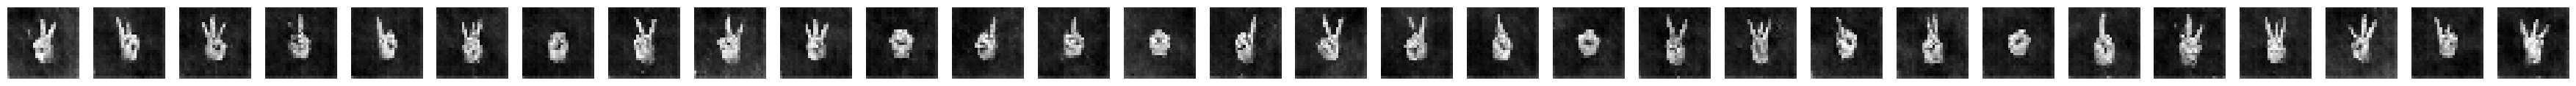

Epoch 61: disc_loss: 0.2991112172603607 | gen_loss: 3.643239736557007
Epoch 61


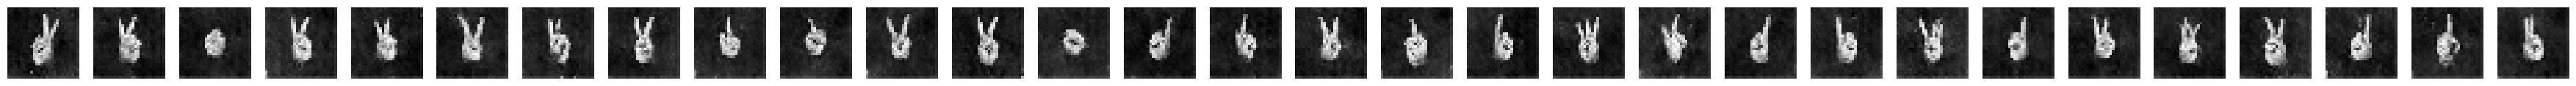

Epoch 62: disc_loss: 0.3355695605278015 | gen_loss: 2.156510591506958
Epoch 62


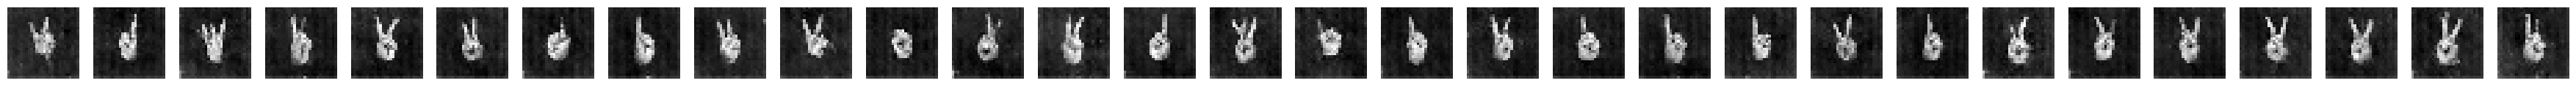

Epoch 63: disc_loss: 0.3743034601211548 | gen_loss: 4.950170516967773
Epoch 63


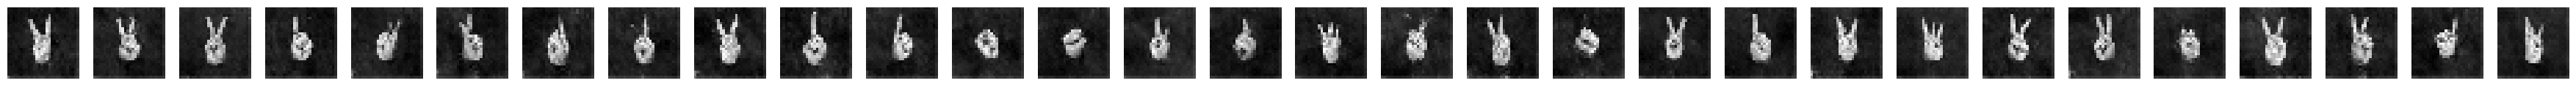

Epoch 64: disc_loss: 0.45549261569976807 | gen_loss: 2.0345420837402344
Epoch 64


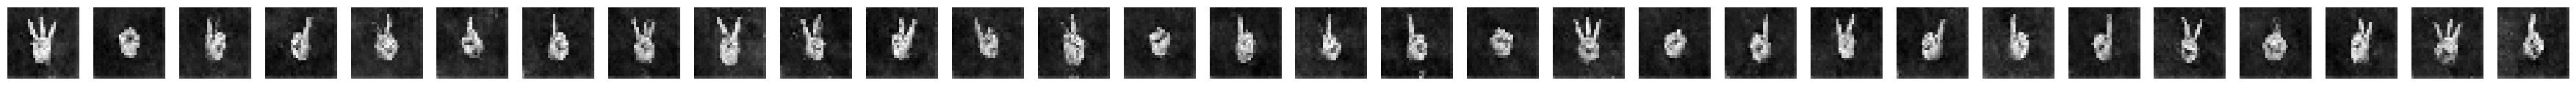

Epoch 65: disc_loss: 0.42986100912094116 | gen_loss: 5.277998924255371
Epoch 65


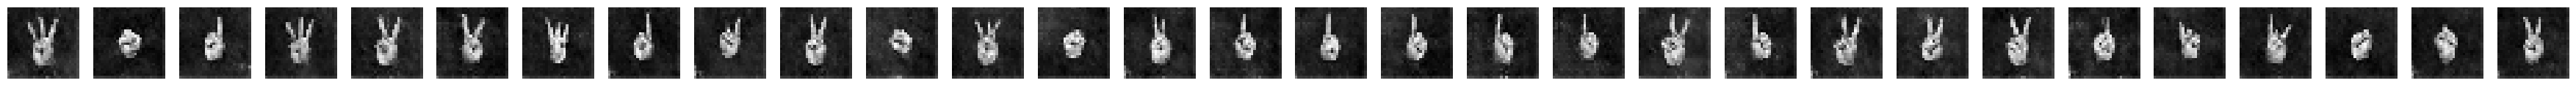

Epoch 66: disc_loss: 0.31208688020706177 | gen_loss: 2.726863384246826
Epoch 66


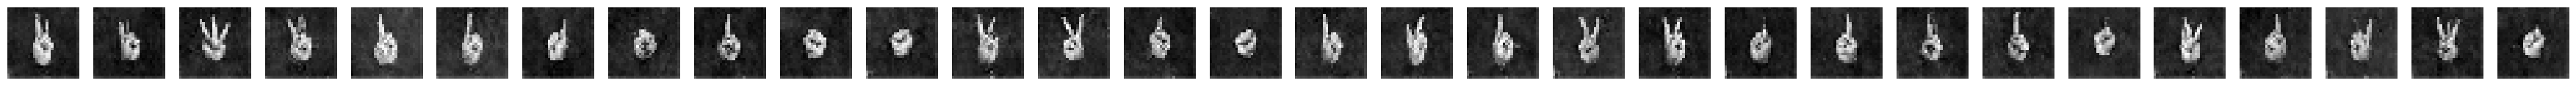

Epoch 67: disc_loss: 0.5854891538619995 | gen_loss: 4.773021697998047
Epoch 67


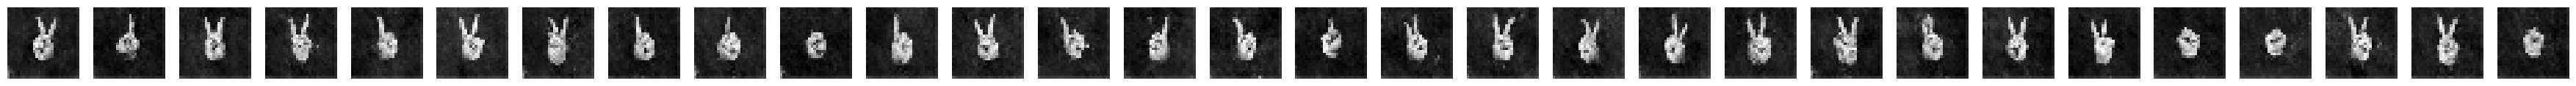

Epoch 68: disc_loss: 0.19079174101352692 | gen_loss: 4.8959856033325195
Epoch 68


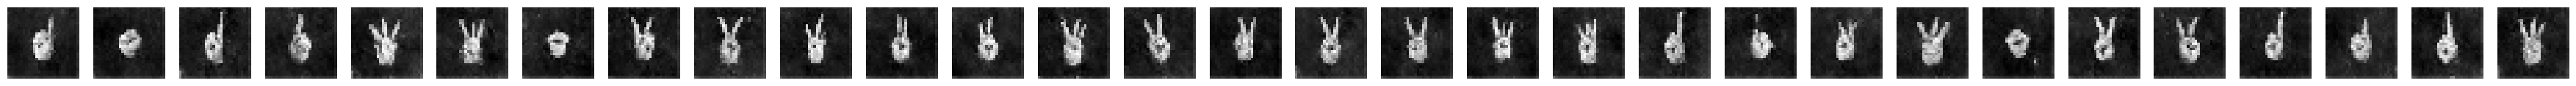

Epoch 69: disc_loss: 0.15221267938613892 | gen_loss: 4.016114234924316
Epoch 69


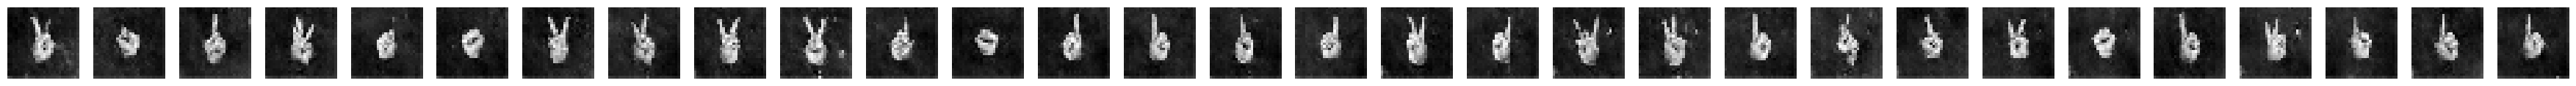

Epoch 70: disc_loss: 0.20368382334709167 | gen_loss: 3.0343775749206543
Epoch 70


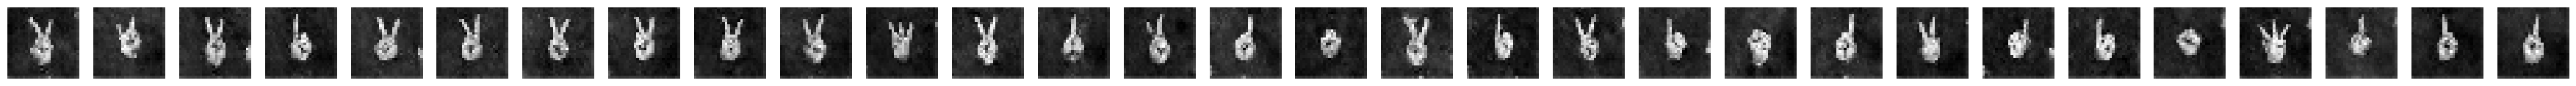

Epoch 71: disc_loss: 0.16751158237457275 | gen_loss: 4.170565128326416
Epoch 71


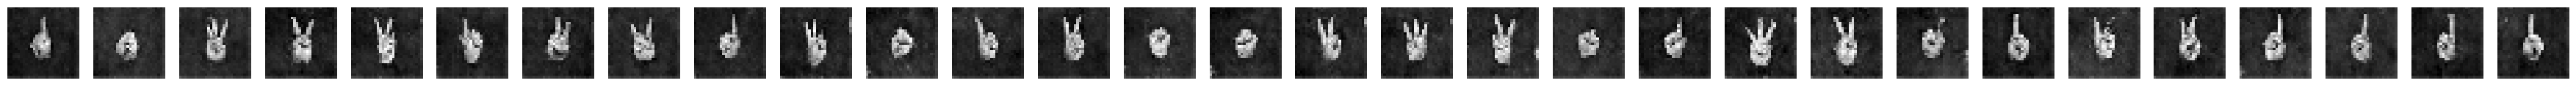

Epoch 72: disc_loss: 0.20864176750183105 | gen_loss: 2.921107053756714
Epoch 72


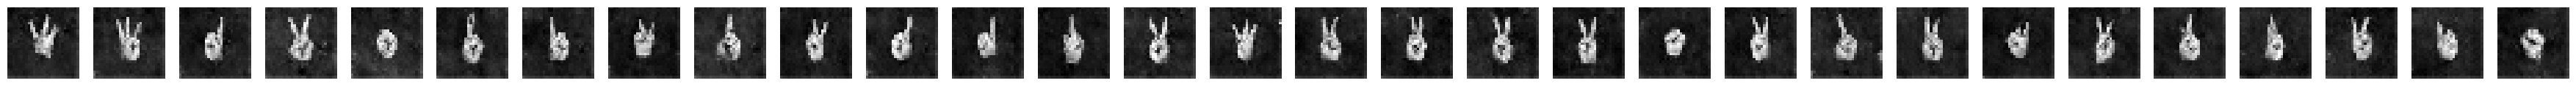

Epoch 73: disc_loss: 0.47995930910110474 | gen_loss: 5.395256042480469
Epoch 73


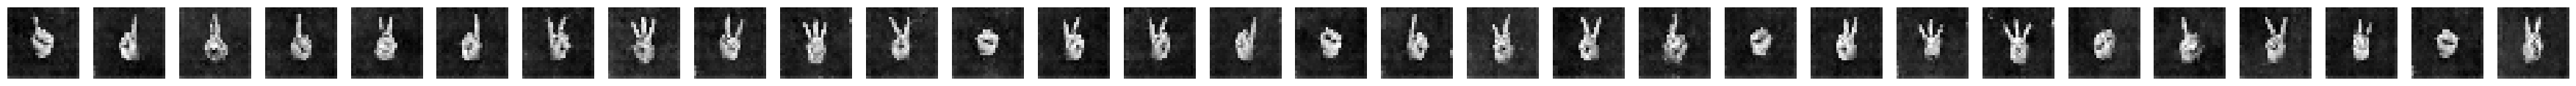

Epoch 74: disc_loss: 0.32418644428253174 | gen_loss: 2.606147527694702
Epoch 74


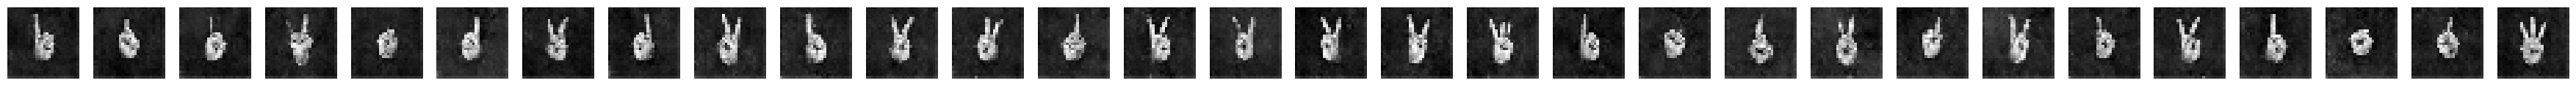

Epoch 75: disc_loss: 0.3521709740161896 | gen_loss: 5.027189254760742
Epoch 75


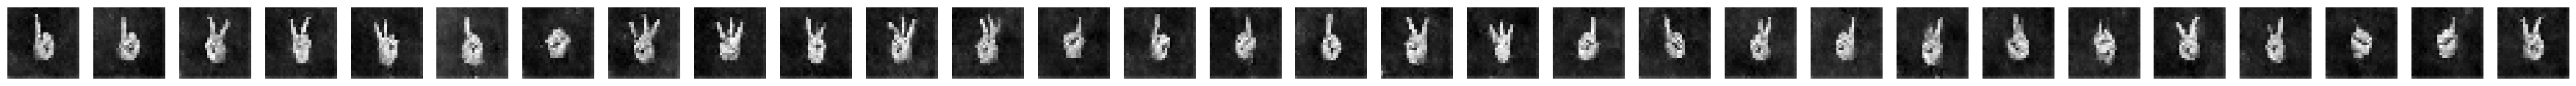

Epoch 76: disc_loss: 0.26461154222488403 | gen_loss: 2.747901678085327
Epoch 76


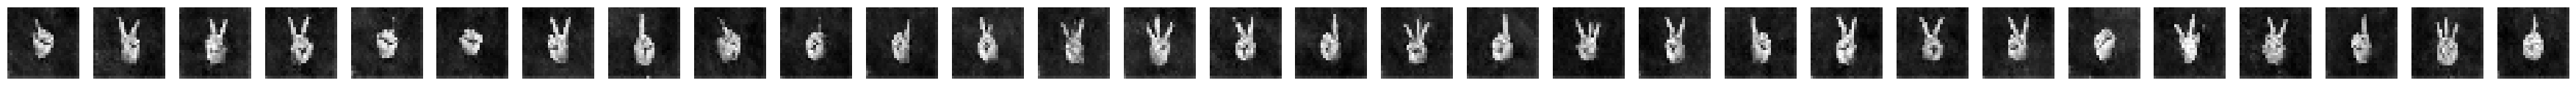

Epoch 77: disc_loss: 0.21602745354175568 | gen_loss: 4.361401081085205
Epoch 77


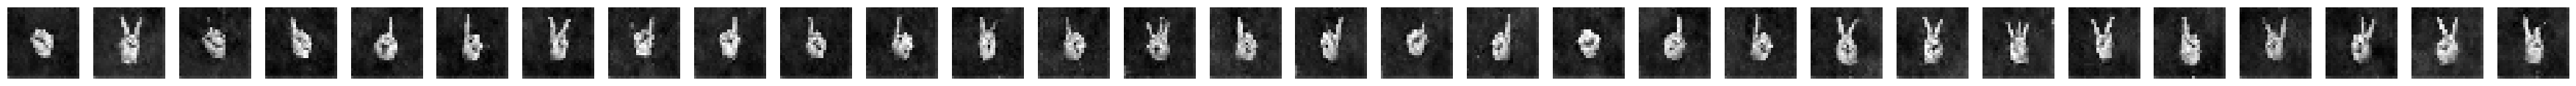

Epoch 78: disc_loss: 0.3063123822212219 | gen_loss: 2.884596824645996
Epoch 78


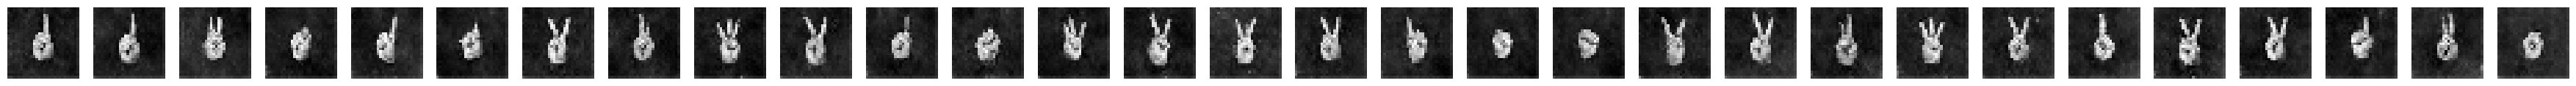

Epoch 79: disc_loss: 0.4570769667625427 | gen_loss: 2.2240312099456787
Epoch 79


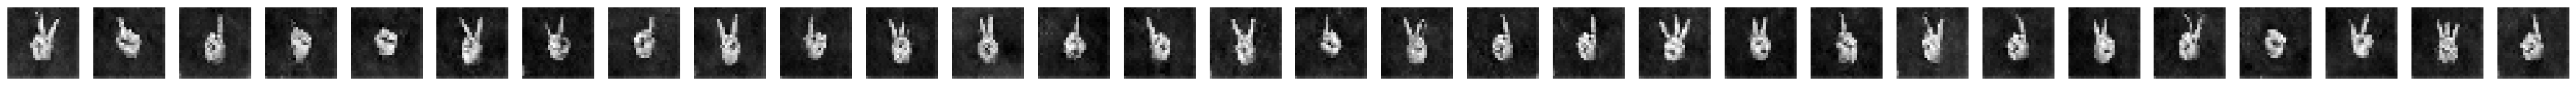

Epoch 80: disc_loss: 0.25041675567626953 | gen_loss: 3.6726584434509277
Epoch 80


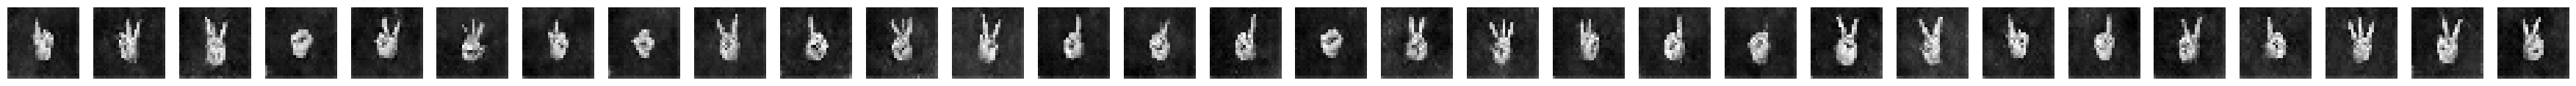

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_reconstruction(model, nex=30, zm=1):
    # Generar 30 muestras a partir del modelo
    samples = model.generate(tf.random.normal(shape=(nex, N_Z)))  # Asegurarse de que N_Z es la dimensión del espacio latente

    # Lista para almacenar las imágenes generadas
    generated_images = []

    for axi in range(nex):
        # Usar un mapa de colores directo para fondo negro e imagen blanca
        # Invertir los valores si es necesario
        image = samples.numpy()[axi].squeeze()
        if np.min(image) < 0:  # Suponiendo que el rango es [-1, 1] y necesitamos invertirlo
            image = -image  # Invertir la imagen para que el fondo sea negro y la imagen sea blanca
        generated_images.append(image)

    return generated_images  # Devolver la lista de imágenes generadas


# Lista para almacenar todas las imágenes generadas en cada época
all_generated_images = []

# DataFrame para almacenar las pérdidas de cada época
losses = pd.DataFrame(columns=['disc_loss', 'gen_loss'])

n_epochs = 80
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)

    # plot results
    display.clear_output()
    print(
        "Epoch {}: disc_loss: {} | gen_loss: {}".format(
            epoch + 1, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )

    # Generar y almacenar imágenes para esta época
    generated_images = plot_reconstruction(model)
    all_generated_images.append(generated_images)

# Mostrar todas las imágenes generadas y las pérdidas correspondientes
for i, epoch_images in enumerate(all_generated_images):
    print(f"Epoch {i+1}: disc_loss: {losses.disc_loss.values[i]} | gen_loss: {losses.gen_loss.values[i]}")
    print(f"Epoch {i+1}")
    fig, axs = plt.subplots(ncols=len(epoch_images), figsize=(len(epoch_images) * 1.5, 1.5))
    for ax, img in zip(axs, epoch_images):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

